In [3]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import numpy as np

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
base_model_path = './mbart-large-51-mans-raw'

In [5]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [6]:
old_len = len(tokenizer)
old_len

261911

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [7]:
tokenizer.lang_code_to_id['mans_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'mans_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'mans_XX' not in tokenizer._additional_special_tokens:
    tokenizer._additional_special_tokens.append('mans_XX')

In [8]:
import pandas as pd

golden_pairs = pd.read_csv('./datasets/train_set_clean.csv')
#golden_pairs.drop(columns=["Unnamed: 0"], inplace=True)
golden_pairs

,Unnamed: 0,ru,mans_raw,domain,mans
0,0,"И было слово Господне к Ионе, сыну Амафиину:","Ионан, Амиттай пы̄гын, Тōрум Āсьныл тамле лāты...",bible_mansi_iona,"Ионан, Амиттай пы̄гын, Тōрум Āсьныл тамле лāты..."
1,1,"И встал Иона, чтобы бежать в Фарсис от лица Го...",Иона э̄лы лё̄ӈхын минас: Тōрум Āсьныл Таршишн ...,bible_mansi_iona,Иона э̄лы лё̄ӈхын минас: Тōрум Āсьныл Таршишн ...
2,2,"И устрашились корабельщики, и взывали каждый к...",Кāраплит рупитан хōтпат пилысьман ёхтувēсыт. К...,bible_mansi_iona,Кāраплит рупитан хōтпат пилысьман ёхтувēсыт. К...
3,3,"И сказали друг другу: пойдем, бросим жребии, ч...",Тāн тāнки халанылт потыртаӈкве патсыт: ”Халувт...,bible_mansi_iona,"Тāн тāнки халанылт потыртаӈкве патсыт: ""Халувт..."
4,4,"И он сказал им: я Еврей, чту Господа Бога небе...","”Ам – еврей, – тав лāвыс, – ам Тōрум Āсь янытл...",bible_mansi_iona,"""Ам - еврей, - тав лāвыс, - ам Тōрум Āсь янытл..."
...,...,...,...,...,...
79543,79577,На двадцать первом заседании окружного парламе...,Та э̄тпост округ дума депутатыт яныг сапра̄ния...,journal,Та э̄тпост округ дума депутатыт яныг сапра̄ния...
79544,79578,"В канун Дня семьи, любви и верности глава реги...",Ты э̄тпос 8 хо̄талэ Ще̄мья янытлан хо̄талыг ла...,journal,Ты э̄тпос 8 хо̄талэ Ще̄мья янытлан хо̄талыг ла...
79545,79579,Губернатор Югры Наталья Комарова провела засед...,Округ кӯщай нэ̄ Наталья Комарова ва̄ӈын хо̄тпа...,journal,Округ кӯщай нэ̄ Наталья Комарова ва̄ӈын хо̄тпа...
79546,79580,В столице республики Мордовия Саранске 17-18 а...,Тынакт Мордовия ма̄т Саранск ӯст рӯтыг о̄лнэ ф...,journal,Тынакт Мордовия ма̄т Саранск ӯст рӯтыг о̄лнэ ф...


In [9]:
golden_pairs.sample(1, random_state=42)

,Unnamed: 0,ru,mans_raw,domain,mans
30667,30699,Но подошёл сбоку старый серый гусь.,О̄с ля̄пан ё̄хтыс по̄хыл ма̄тум сэ̄мыл лӯнт.,overall_80K,О̄с ля̄пан ё̄хтыс по̄хыл ма̄тум сэ̄мыл лӯнт.


In [10]:
all_pairs = []
for ru_sent, mans_sent in zip(golden_pairs['ru'], golden_pairs['mans']):
    all_pairs.append((mans_sent, ru_sent))

In [11]:
print(len(all_pairs))

79548


In [12]:
import random

random.choice(all_pairs)

('Ювле хультум та̄лт Ха̄льӯст о̄лнэ краеведческий музей-кол рӯпитаӈкв о̄вылтахтаме па̄сныл налыман та̄лэ то̄влыс.',
 'В прошлом году Березовскому краеведческому музею с начала открытия исполнилось  сорок лет.')

## Training

In [13]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [14]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path).to("cuda")

In [ ]:
#model.cuda();

In [15]:
!nvidia-smi

Wed Sep 11 15:20:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:8C:00.0 Off |                    0 |
| N/A   31C    P0              40W / 250W |   2702MiB / 32768MiB |     44%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### First, update just the new embeddings

In [16]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [17]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [18]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [19]:
tokenizer.src_lang = "mans_XX"
tokenizer.tgt_lang = "ru_RU"

In [20]:
#wandb logging
%pip install wandb -qU 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [21]:
# Log in to your W&B account
import wandb
import os

# Use wandb-core, temporary for wandb's new backend
wandb.require("core")

wandb.login(key="8c745c35783186f823a53c1d97aeb0c334c92530")

wandb.init(
    # set the wandb project where this run will be logged
    project="mans-ru-translation-mbart_newest",
)

# optional: track gradients
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: Currently logged in as: anastmezentseva (naughty-research). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.9
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20240911_152106-oa5qspzs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run soft-hill-1
wandb: ⭐️ View project at https://wandb.ai/naughty-research/mans-ru-translation-mbart_newest
wandb: 🚀 View run at https://wandb.ai/naughty-research/mans-ru-translation-mbart_ne

[]

In [22]:
def train_log(loss, step, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=step)
    print('step:', step, 'loss:', np.mean(losses[-report_steps:]))

In [23]:
tokenizer;

In [24]:
model;

In [25]:
import warnings

warnings.filterwarnings("ignore")

In [26]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in range(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer(text_target=[p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256,
                         ).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            train_log(loss=np.mean(losses[-report_steps:]), step=i, epoch=epoch)

EPOCH 0
step: 0 loss: 12.817821502685547
step: 500 loss: 9.007784481048583
step: 1000 loss: 3.993683699131012
step: 1500 loss: 2.9162477648258207
step: 2000 loss: 2.642485165119171
step: 2500 loss: 2.46421226143837
step: 3000 loss: 2.309457872867584
step: 3500 loss: 2.2225773978233336
step: 4000 loss: 2.1906320974826814
step: 4500 loss: 2.1046005381345747
step: 5000 loss: 2.038357049167156
step: 5500 loss: 2.0228090052604677
step: 6000 loss: 1.9865355725288392
step: 6500 loss: 1.9350762286186218
step: 7000 loss: 1.9127248221635818
step: 7500 loss: 1.8841693474054337
step: 8000 loss: 1.8610271778106688
step: 8500 loss: 1.8431924169063567
step: 9000 loss: 1.7945015221834182
step: 9500 loss: 1.7835833138227464


Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [27]:
save_model_path = './mbart-large-51-mans-ru-v3'

In [28]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


('./mbart-large-51-mans-ru-v3/tokenizer_config.json',
 './mbart-large-51-mans-ru-v3/special_tokens_map.json',
 './mbart-large-51-mans-ru-v3/sentencepiece.bpe.model',
 './mbart-large-51-mans-ru-v3/added_tokens.json')

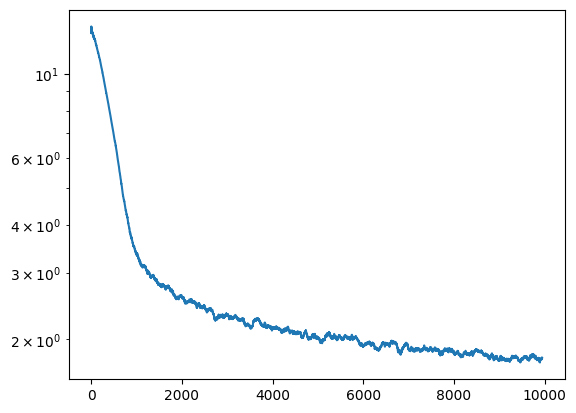

In [29]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [32]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [34]:
for p in model.model.shared.parameters():
    print(p.requires_grad)

True


In [37]:
def train_log(loss, step, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=step)
    print('step:', step, 'loss:', np.mean(losses[-report_steps:]))

In [38]:
loss = None
# optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [39]:
for p in model.parameters():
    p.requires_grad = True

In [40]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [41]:
batch_size = 8 # 8
report_steps = 500 
epochs = 5 #3
losses = []

In [42]:
import random

save_model_path = './mbart-large-51-mans-ru-v3-full-finetune'

Optimizing all parameters takes x1.5 longer than just embeddings (4h): about 6h per epoch. 

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in range(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            train_log(loss=np.mean(losses[-report_steps:]), step=9500 *(epoch+1) + i, epoch=epoch) #9500 steps was maded previosly

EPOCH 0
step: 9500 loss: 1.6916457208411952
step: 10000 loss: 1.5837422499656677
step: 10500 loss: 1.5792288346290588
step: 11000 loss: 1.5257004920244217
step: 11500 loss: 1.5121085098981857
step: 12000 loss: 1.4850340476036072
step: 12500 loss: 1.4825463804006576
step: 13000 loss: 1.4395914198160171
step: 13500 loss: 1.4602354239225388
step: 14000 loss: 1.4198234568834305
step: 14500 loss: 1.4492253462672233
step: 15000 loss: 1.389571104645729
step: 15500 loss: 1.3853098685741425
step: 16000 loss: 1.391355249941349
step: 16500 loss: 1.3813642497062684
step: 17000 loss: 1.3762077152729035
step: 17500 loss: 1.3743580590486526
step: 18000 loss: 1.3721660377383231
step: 18500 loss: 1.3428046408891678
step: 19000 loss: 1.359988446354866
EPOCH 1
step: 19000 loss: 1.344715546488762
step: 19500 loss: 1.3391720646619796
step: 20000 loss: 1.3004681563973426
step: 20500 loss: 1.3031087234020233
step: 21000 loss: 1.2762745372653008
step: 21500 loss: 1.2965712070465087
step: 22000 loss: 1.2742938

In [ ]:
model.save_pretrained(save_model_path + f"epoch_4")
tokenizer.save_pretrained(save_model_path + f"epoch_4")

The final loss was about 1.01.

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(1000).mean().plot();
plt.yscale('log');

In [ ]:
# model.save_pretrained('mbart-large-51-ru-mans-v1-full-finetune-5-epochs')
# tokenizer.save_pretrained('mbart-large-51-ru-mans-v1-full-finetune-3-epochs')

In [20]:
model.eval();

In [70]:
mans, ru = random.choice(all_pairs)
mans, ru

('Юв щалтсӯв, потрамēв, толтыглахтэв, ща̄й аюӈкве ӯнтсӯв. ',
 'Домой зашли, разговариваем, согрелись, стали чай пить. ')

In [71]:
def translate(text, src='ru_RU', trg='mans_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(ru)

'Юв ёхтысыт, потырēв, исумсув, ща̄йаюӈкве патсыт.'

In [74]:
mans, ru = random.choice(all_pairs)
mans, ru

('Тамле яныг рӯпатакапай ты ёмас сымыӈ хо̄тпа Светлана Алексеевна ты ва̄ри.',
 'Такую большую работу выполняет добрая женщина Светлана Алексеевна.')

In [75]:
translate(ru)

'Тамле яныг рӯпата ёмас э̄ква Светлана Алексеевна ва̄ри.'